# Practicing & Showing workflow for crop and align DL with ROI workflow. Comments explain what each blobs of line does. Don't run workflow here, scroll down to run the actual function!

In [1]:
# import pandas as pd
from PIL import Image
Image.MAX_IMAGE_PIXELS=None
import numpy as np
from skimage.measure import label
from skimage.morphology import closing, square, remove_small_objects, remove_small_holes
from math import atan2, degrees
import os
from copy import deepcopy
import cv2
from time import time
import pandas as pd
from natsort import natsorted
import matplotlib.pyplot as plt

def rotate_image_cv2(mat, angle):
    """
    Helper function used in pipeline:
    Rotates an image (angle in degrees) and expands image to avoid cropping
    Image has to be uint8
    """

    height, width = mat.shape[:2] # image shape has 3 dimensions
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0])
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h),	flags = cv2.INTER_NEAREST)
    return rotated_mat

In [4]:
imsrc = r'\\shelter\Kyu\skin_aging\clue_cohort\HE1um' # 1um resolution, same size as dlsrc
dlsrc = r'\\shelter\Kyu\skin_aging\clue_cohort\DLmask1um' # 1um resolution, same size as imsrc
roisrc = r'\\shelter\Kyu\skin_aging\clue_cohort\annotations\roi\labeledmask_20rsf' # need to resize to imsrc/dlsrc size

In [5]:
roiflag = True

minTA = 20000
minTAhole = 100
minDermhole = 5000
minepisize = 1000
whitespace = 12

if roiflag:
    imdst = os.path.join(imsrc, 'kevin_imcrop_roiv2')
    if not os.path.exists(imdst): os.mkdir(imdst)
    imdst2 = os.path.join(imdst, 'kevin_imcrop_roi_10umv2')
    if not os.path.exists(imdst2): os.mkdir(imdst2)
    dldst = os.path.join(dlsrc, 'kevin_dlcrop_roiv2')
    if not os.path.exists(dldst): os.mkdir(dldst)
else:
    imdst = os.path.join(imsrc, 'imcropv2')
    if not os.path.exists(imdst): os.mkdir(imdst)
    imdst2 = os.path.join(imdst, 'imcrop_10umv2')
    if not os.path.exists(imdst2): os.mkdir(imdst2)
    dldst = os.path.join(dlsrc, 'dlcropv2')
    if not os.path.exists(dldst): os.mkdir(dldst)

imlist = [os.path.join(imsrc, _) for _ in os.listdir(imsrc) if _.endswith('tif')]
dllist = [os.path.join(dlsrc, _) for _ in os.listdir(dlsrc) if _.endswith('tif')]
imlist = natsorted(imlist)
dllist = natsorted(dllist)

df = []

idx=0
# test random image
imname = imlist[1]
dlname = dllist[1]
start = time()


imfn, ext = os.path.splitext(os.path.basename(imname))
dlfn, ext = os.path.splitext(os.path.basename(dlname))
roiname = os.path.join(roisrc, imfn+'.png')

isim = os.path.exists(os.path.join(imdst, '{}_sec{:02d}.png'.format(imfn, 1)))
isdl = os.path.exists(os.path.join(imdst, '{}_sec{:02d}.png'.format(dlfn, 1)))
if isim and isdl:
    print('continue')

print(imfn)
print('idx:',idx)

# open image
dl = Image.open(dlname)
im = Image.open(imname)

if not im.size == dl.size:
    raise Exception("im and dl dimensions do not match")

TAbig = np.array(dl)

if roiflag:
    roi = np.array(Image.open(roiname))

# downsize to expedite (downsize deeplab mask)
(width, height) = (dl.width // 10, dl.height // 10)

TA = cv2.resize(TAbig, dsize=(width,height), interpolation=cv2.INTER_NEAREST) #1~10

sure_fg = closing((2 < TA) & (TA < whitespace - 1), square(3))  # 13sec # close small holes in DLmask
sure_fg = remove_small_objects(sure_fg, min_size=minTA, connectivity=2)  # 6sec
sure_fg = remove_small_holes(sure_fg, area_threshold=minTAhole).astype(np.uint8)  # 7sec
# define background
bw = closing(TA < whitespace, square(3))  # 12 is background
bw = remove_small_objects(bw, min_size=minTA, connectivity=2)
bw = remove_small_holes(bw, area_threshold=minTAhole)
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(bw.astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations=2)  # 2sec #difference between erosion and dilation, gives outline of object
sure_bg = cv2.dilate(opening, kernel, iterations=3)

2022-06-07 13.29.45
idx: 0


In [24]:
im.size

(44088, 25492)

In [4]:
dl.size

(44088, 25492)

In [5]:
(dl.width // 10, dl.height // 10)

(4408, 2549)

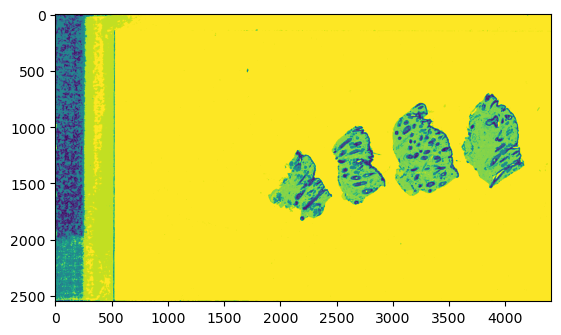

In [6]:
plt.imshow(TA)

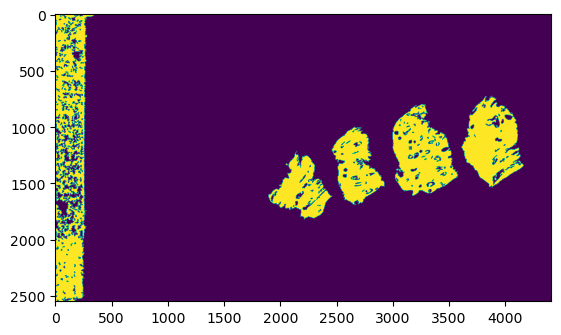

In [7]:
plt.imshow(sure_fg)

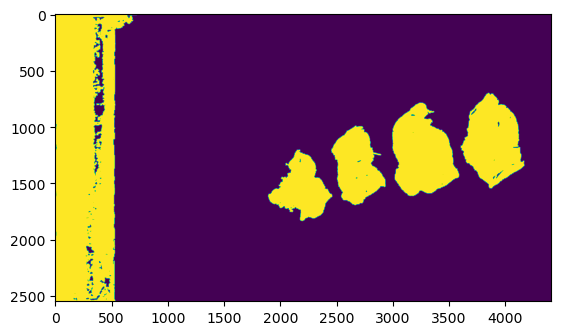

In [8]:
plt.imshow(sure_bg)

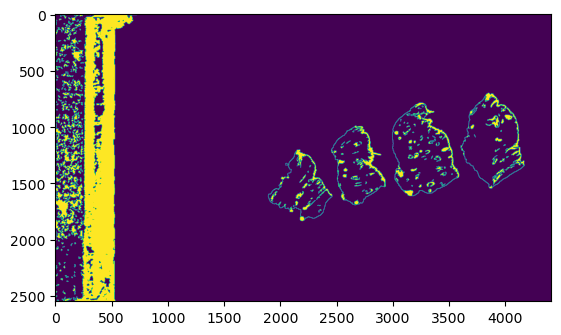

In [9]:
# define middleground
unknown = cv2.subtract(sure_bg, sure_fg).astype('bool') # foreground - background = gives you the outline of the image.
plt.imshow(unknown)

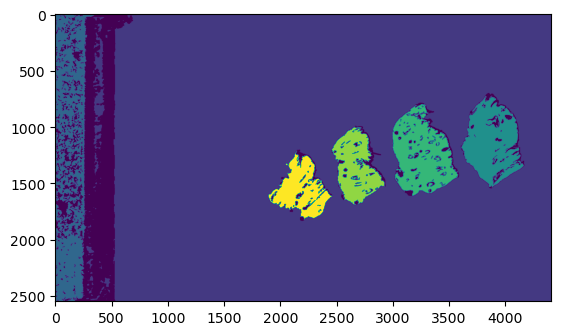

In [10]:
# label that background is 1 and objects are 2~N and middleground is zero -> the middleground meaning the outline of the object "unknown", this value is labeled 0. The background (black) is labeled as 1, and each object (usually four tissue in one section) is labeled from 2,3,4,5....
sure_fg_label = label(sure_fg).astype(np.int32)
sure_fg_label = sure_fg_label + 1
sure_fg_label[unknown] = 0
plt.imshow(sure_fg_label) #these are the markers

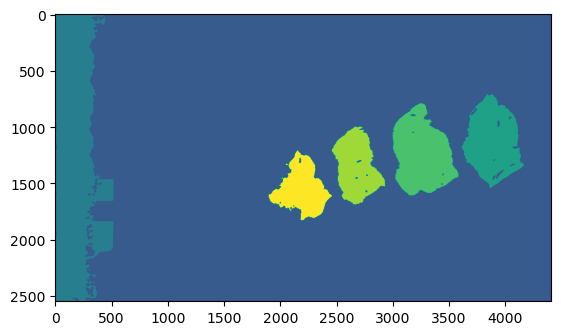

In [11]:
# perform watershed based on the marker
TAbgr = cv2.cvtColor(TA, cv2.COLOR_GRAY2BGR) #RGB image
label_image = cv2.watershed(TAbgr, sure_fg_label)
numsecmax = np.max(label_image) # max number of labeled images
plt.imshow(label_image) #background one color, and the four tissues each have a color


7 sec elapsed for overhead


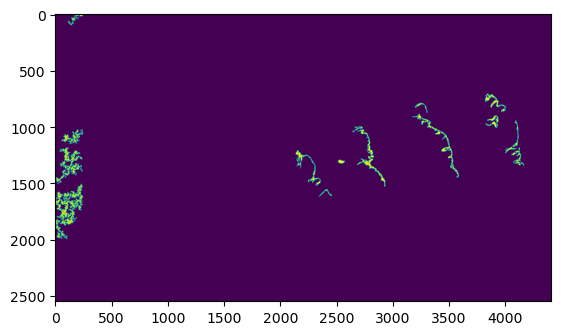

In [12]:
# iterate each section
epi = (TA == 1) | (TA == 2) #epidermis
derm = (2 < TA) & (TA < whitespace) # all the rest of the dermis
derm = remove_small_holes(derm, area_threshold=minDermhole)
epi2 = epi & ~derm #only isolate epidermis
epi2 = remove_small_objects(epi2, min_size=minepisize, connectivity=2) # this returns the epidermis part of the entire image!
print(round(time() - start), 'sec elapsed for overhead')
plt.imshow(epi2)

In [13]:
numsec=1
print('section N: ', numsec, '/', numsecmax - 1)
# try:
start = time()
msktmp = label_image == numsec + 1 # first object of the tissue (out of the 4)

# mskderm = msktmp & derm
mskepi = msktmp & epi2 # so this returns mskepi, which is the epidermis of the first object of the tissue. So therefore count is section N: 1/4 !

section N:  1 / 5


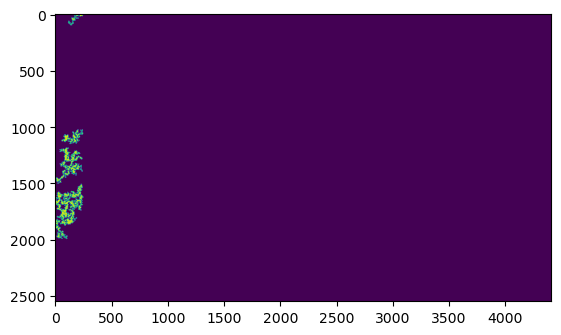

In [14]:
plt.imshow(mskepi)

In [15]:
if roiflag:
    roi2 = cv2.resize(roi, dsize=(width, height), interpolation=cv2.INTER_NEAREST) # the roi of the image resized as well.
    msktmp = np.multiply(msktmp, roi2 > 0)
if not msktmp.any(): # if roi doesn't cover the mask of the first tissue object, then we didn't annotate the roi of it, so it's a non-healthy section. in this case, msktmp will be blank background
    print('non healthy section,',numsec)

non healthy section, 1


In [ ]:
# align horizontal so that the epidermis is at the top, with dermis at the bottom of epidermis.

# find orientation of the current image by using svd decomposition and the arctan of the sin and cos of the rotational matrix
[xt2, yt2] = np.where(mskepi)
vertices = np.array([xt2[::10], yt2[::10]]).T
vc = vertices - vertices.mean(axis=0)
U, S, Vt = np.linalg.svd(vc)
k = Vt.T
d0 = degrees(atan2(k[1, 1], k[1, 0]))  # arctan of sin/cos in degrees
d0special = False
if np.linalg.det(k) < 0:
    d0special = True
    d0 = -d0
if d0 < 0: d0 = d0 + 360
print(round(time() - start), 'sec elapsed for rotational matrix calculation')

start = time()
TAtmp = deepcopy(TAbig)

# resize and  dilates the binary mask to match the size of the original image.

mskbig = cv2.resize(msktmp.astype(np.uint8), TAtmp.shape[::-1], interpolation=cv2.INTER_NEAREST)
kernel = np.ones((20, 20), np.uint8)
mskbig = cv2.dilate(mskbig, kernel, iterations=3)
TAtmp[mskbig == 0] = 0  # scale back up to perform rotation #1sec

# Rotates the original image and the binary mask using the calculated orientation.

[xt0, yt0] = np.where(mskbig)  # mskrot is sometimes not detected
TAtmp2 = TAtmp[np.min(xt0):np.max(xt0), np.min(yt0):np.max(yt0)]

mskrot = rotate_image_cv2(TAtmp2, d0)
[xt, yt] = np.where(mskrot)  # mskrot is sometimes not detected
print(round(time() - start), 'sec elapsed for DL rotation and cropping')

start = time()
[xt2, yt2] = np.where((mskrot == 1) | (mskrot == 2))
d0Flip = False
# Flips the binary mask if the dermis part is above the epidermis part.

if np.mean(xt) - np.mean(xt2) < 0:  # if dermis is above epidermis, flip it
    d0Flip = True
    mskrot = np.rot90(np.rot90(mskrot))
    d0 += 180
#repeat crop in case original is flipped
[xt, yt] = np.where(mskrot)  # mskrot is sometimes not detected
mskrot2 = mskrot[np.min(xt):np.max(xt), np.min(yt):np.max(yt)]
print(round(time() - start), 'sec elapsed for calculating flip')
# Multiplies the original image by the binary mask to obtain a masked image
start = time()  # 10sec
imtmp = np.multiply(im, np.repeat(mskbig[:, :, np.newaxis], 3, axis=2))
imtmp2 = imtmp[np.min(xt0):np.max(xt0), np.min(yt0):np.max(yt0)]
imrot = rotate_image_cv2(imtmp2, d0)
print(round(time() - start), 'sec elapsed for H&E rotation')

#Crops the rotated masked image to include only the regions with positive values

start = time()  # 10sec
imrot2 = imrot[np.min(xt):np.max(xt), np.min(yt):np.max(yt)]
lmask = np.repeat(np.multiply(np.logical_not(imrot2[:, :, 0] > 0)[:, :, np.newaxis], 230, dtype=np.uint8),
                  3,
                  axis=2)
imrot3 = np.add(imrot2,lmask)
print(round(time() - start), 'sec elapsed for H&E cropping')

mskrot2[mskrot2 == 0] = whitespace
start = time()  # 10sec

# save mask, masked image, and downsized masked image by 10.
Image.fromarray(mskrot2.astype('int8')).save(
    os.path.join(dldst, '{}_sec{:02d}.png'.format(dlfn, numsec)))

Image.fromarray(imrot3.astype('uint8')).save(
    os.path.join(imdst, '{}_sec{:02d}.png'.format(imfn, numsec)),optimize=True)

Image.fromarray(imrot3.astype('uint8')).resize([_ // 10 for _ in imrot3.shape][:2][::-1], resample=1).save(
    os.path.join(imdst2, '{}_sec{:02d}.png'.format(dlfn, numsec)), optimize=True)
print(round(time() - start), 'sec elapsed for writing images')

#
df.append({'imID': idx, 'imname': imfn, 'secN': numsec, 'k': k.flatten(), 'degrot': round(d0, 2), 'd0special':d0special, 'd0Flip':d0Flip})
df2 = pd.DataFrame(df)
df2.to_excel(os.path.join(imdst, 'CLUE_rotation_LUT_v2.csv'))

# Now run the actual function:

In [1]:
# import pandas as pd
from PIL import Image
Image.MAX_IMAGE_PIXELS=None
import numpy as np
from skimage.measure import label
from skimage.morphology import closing, square, remove_small_objects, remove_small_holes
from math import atan2, degrees
import os
from copy import deepcopy
import cv2
from time import time
import pandas as pd
from natsort import natsorted
import matplotlib.pyplot as plt

def rotate_image_cv2(mat, angle):
    """
    Helper function used in pipeline:
    Rotates an image (angle in degrees) and expands image to avoid cropping
    Image has to be uint8
    """

    height, width = mat.shape[:2] # image shape has 3 dimensions
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0])
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h),	flags = cv2.INTER_NEAREST)
    return rotated_mat

In [2]:
from crop_align_DL_withROI_edit import crop_align_DL

In [ ]:
crop_align_DL(imsrc = r'\\shelter\Kyu\skin_aging\clue_cohort\HE1um', # 1um resolution, same size as dlsrc
dlsrc = r'\\shelter\Kyu\skin_aging\clue_cohort\DLmask1um', # 1um resolution, same size as imsrc
roisrc = r'\\shelter\Kyu\skin_aging\clue_cohort\annotations\roi\labeledmask_20rsf',xlsrc=r'\\shelter\Kyu\skin_aging\clue_cohort\CLUE_roi_composition.xlsx')

2022-06-07 13.18.40
idx: 0
1 sec elapsed for overhead
section N:  1 / 4
non healthy section, 1
section N:  2 / 4
0 sec elapsed for rotational matrix calculation
2 sec elapsed for DL rotation and cropping
0 sec elapsed for calculating flip
37 sec elapsed for H&E rotation
0 sec elapsed for H&E cropping
3 sec elapsed for writing images
section N:  3 / 4
non healthy section, 3
section N:  4 / 4
non healthy section, 4
2022-06-07 13.29.45
idx: 1
4 sec elapsed for overhead
section N:  1 / 5
non healthy section, 1
section N:  2 / 5
0 sec elapsed for rotational matrix calculation
5 sec elapsed for DL rotation and cropping
0 sec elapsed for calculating flip
77 sec elapsed for H&E rotation
0 sec elapsed for H&E cropping
3 sec elapsed for writing images
section N:  3 / 5
0 sec elapsed for rotational matrix calculation
5 sec elapsed for DL rotation and cropping
1 sec elapsed for calculating flip
7 sec elapsed for H&E rotation
0 sec elapsed for H&E cropping
4 sec elapsed for writing images
section N